# Handling credentials with .env files

**NEVER** put your credentials in your code!

An .env file is a simple text file that contains your credentials:

```
GEMINI_API_KEY=...
OPENAI_API_KEY=...
HUGGINFACE_API_KEY=...
```

Create it in your repository and **make sure to use a .gitignore file** with a line containing `.env`. This way it will be much more difficult to commit the .env file by mistake.

A good practice is to provide a `env.example` file with some mock credentials, so whoever is going to use your code will just have to do:

```bash
cp env.example .env
```
and then edit the .env file.

In [6]:
# Load credentials for Gemini
from dotenv import load_dotenv
load_dotenv()

# Now all the variables in the .env file are available as:
# os.environ.get("[variable name]"), for example:
# os.environ.get("GEMINI_API_KEY")

True

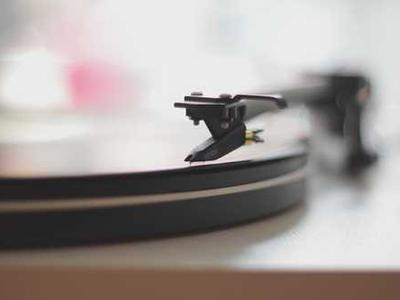

In [7]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def get_image_from_url(image_url: str) -> Image.Image:
    
    return Image.open(BytesIO(requests.get(image_url).content)).copy()
    

def display_image_with_caption(image: Image.Image, caption: str):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption, wrap=True, fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

# This URL generates a random JPG image every time you call it!
image_url = "https://picsum.photos/400/300"
image = get_image_from_url(image_url)
image

In [8]:
prompt = "Describe this image briefly"

# The following is for huggingface
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": prompt},
        ]
    },
]

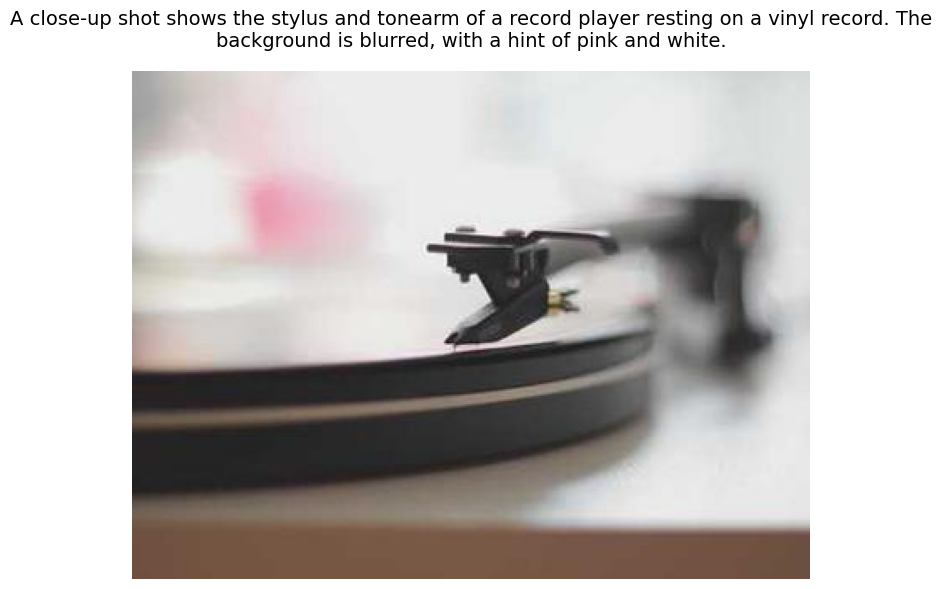

In [9]:
import os
from google import genai
from google.genai import types


def analyze_image_with_gemini(img: Image.Image, prompt: str) -> str:
    
    client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))

    config = types.GenerateContentConfig(
        # Set thinking to 0 to save some money and get a faster response
        thinking_config=types.ThinkingConfig(thinking_budget=0)
    )

    # Limit size to at most 600x600 to limit the usage of tokens
    img.thumbnail((600, 600))

    # Format image for Gemini call
    image_bytes = BytesIO()
    img.save(image_bytes, format='JPEG')
    image_part = types.Part.from_bytes(data=image_bytes.getvalue(), mime_type='image/jpeg')

    # Call Gemini
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=[prompt, image_part],
        config=config
    )
    
    return response.text
    
caption = analyze_image_with_gemini(
    image,
    prompt
)

display_image_with_caption(image, caption)

processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Device is cpu


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

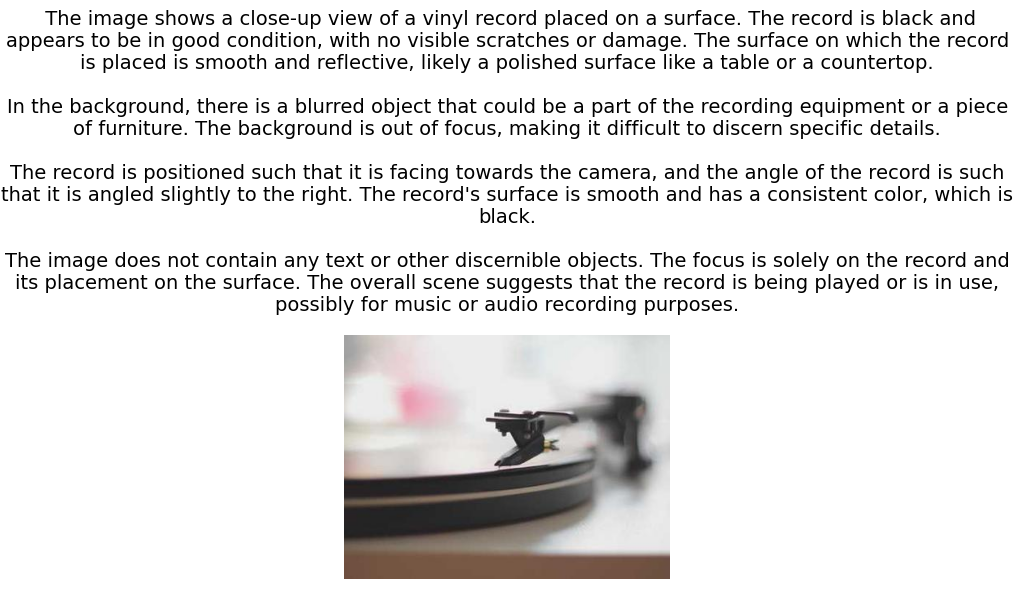

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

model_path = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"
processor = AutoProcessor.from_pretrained(model_path)

model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype=torch.float16, device_map="auto"
)

inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device, dtype=torch.float16)

# This takes around 10 seconds on GPU, around 4 minutes on a CPU
generated_ids = model.generate(
    **inputs, 
    do_sample=False, 
    max_new_tokens=512,
    eos_token_id=processor.tokenizer.eos_token_id,  # Ensure EOS token stops generation
    pad_token_id=processor.tokenizer.eos_token_id
)
generated_texts = processor.batch_decode(
    # We slice here to avoid decoding our own prompt, and instead
    # only decode the output of the model
    generated_ids[:, inputs['input_ids'].shape[1]:],
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True
)
caption = generated_texts[0]

display_image_with_caption(image, caption)

In [ ]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3-turbo"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

# This takes a few seconds on a T4 GPU and around 1 m on CPU
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

# NOTE: this requires ffmpeg to be installed in your system
# This is the text spoken in this file:
# Many animals of even complex structure which live parasitically within others are wholly devoid of an alimentary cavity.
result = pipe("LJ025-0076.wav")

print(f"Transcribed text:\n\n{result['text']}")

Device set to use cpu
`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


Transcribed text:

 many animals of even complex structure which live parasitically within others are wholly devoid of an alimentary cavity
